<a href="https://colab.research.google.com/github/fininsight/nlp-deeplearning-tutorial/blob/master/02_Prac_1_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Word Embedding

#1 Word2Vec

##1.1 Skip-gram 직접구현

In [141]:
docs = ["natural language processing and machine learning is fun and exciting",
        "natural language processing and machine learning"]

In [142]:
from collections import defaultdict
import numpy as np 

class OneHotEncoder() :
  def __init__(self, docs) :
    # 고유 단어와 인덱스를 매칭시켜주는 사전 생성
    self.w2i = defaultdict(lambda:len(self.w2i))
    [self.w2i[w] for d in docs for w in d]
    self.i2w = {v:k for k,v in self.w2i.items()}

  def _get_one_hot_vector(self, w):
    v = [0]*len(self.w2i)
    v[self.w2i[w]] = 1
    return v

  def encode(self, docs) :
    ret = []
    for d in docs :
      tmp = []
      for w in d :
        tmp.append(self._get_one_hot_vector(w))
      ret.append(tmp)
    return ret

  def decode(self, v) :
    return self.i2w[v.index(1)]

![대체 텍스트](https://miro.medium.com/max/1400/1*uuVrJhSF89KGJPltvJ4xhg.png)

In [234]:
import numpy as np
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt

class Word2Vec() :
  def __iniit__(self):
    pass

  def _slide_window(self, encoded_docs, win_size = 2) :
    ret = []

    for d in encoded_docs : 
      win_doc = []
      for i, w in enumerate(d) :
        s, e = max(0, i - win_size), min(len(d), i + win_size)
        context = d[s:e+1]
        center = context.pop(i-s)
        win_doc.append((center, context))
      ret.append(win_doc)
    return ret

  def _softmax(self, output) :
    return np.exp(output) / np.sum(np.exp(output))

  #SGD to backpropagate errors 
  def _backpropagation(self, W1, W2, hidden, predict, center, context, learning_rate) :
      err = (self._softmax(predict) - context).sum(axis=0)

      delta_W2 = np.outer(hidden, err)
      delta_W1 = np.outer(center, np.dot(W2, err))

      W1 = W1 - learning_rate * delta_W1
      W2 = W2 - learning_rate * delta_W2

      return W1, W2

  def embedding(self, docs, method = 'sg', win_size = 2, embedding_size = 5, learning_rate = 0.001, epoch = 10 ) :
    if method == 'sg' :
      return self._skipgram(docs, win_size, embedding_size, learning_rate, epoch)
    elif method == 'cbow' :
      return self._cbow(docs, win_size, embedding_size, learning_rate, epoch)

  def _cbow(self, docs, win_size = 2, embedding_size = 5, learning_rate = 0.001, epoch = 10) :
    tokenized_docs = [d.split() for d in docs]
    ohe = OneHotEncoder(tokenized_docs)
    encoded_docs = ohe.encode(tokenized_docs)
    
    onehot_size = len(encoded_docs[0][0])
    W1 = np.random.rand(onehot_size, embedding_size)
    W2 = np.random.rand(embedding_size, onehot_size)

    sliding_docs = self._slide_window(encoded_docs, win_size)
    for i in tqdm(range(epoch), desc='word embedding') :
      for d in  sliding_docs:
        for center, context in d : 
          #이 부분 고쳐햐암
          hidden = np.dot(context, W1)
          predict = np.dot(hidden, W2)
          W1, W2 = self._backpropagation(W1, W2, hidden, predict, context, center, learning_rate)
      #self.loss += C*np.log(np.sum(np.exp(self.u))) 
    
    self.i2w = ohe.i2w
    self.wv_ = {self.i2w[i]:list(we) for i, we in enumerate(W1)}
    self.word_vectors = W1

    return self.wv_

    pass

  def _skipgram(self, docs, win_size = 2, embedding_size = 5, learning_rate = 0.001, epoch = 10) :
    tokenized_docs = [d.split() for d in docs]
    ohe = OneHotEncoder(tokenized_docs)
    encoded_docs = ohe.encode(tokenized_docs)
    
    onehot_size = len(encoded_docs[0][0])
    W1 = np.random.rand(onehot_size, embedding_size)
    W2 = np.random.rand(embedding_size, onehot_size)

    sliding_docs = self._slide_window(encoded_docs, win_size)
    for i in tqdm(range(epoch), desc='word embedding') :
      for d in  sliding_docs:
        for center, context in d : 
          hidden = np.dot(center, W1)
          predict = np.dot(hidden, W2)
          W1, W2 = self._backpropagation(W1, W2, hidden, predict, center, context, learning_rate)
      #self.loss += C*np.log(np.sum(np.exp(self.u))) 
    
    self.i2w = ohe.i2w
    self.wv_ = {self.i2w[i]:list(we) for i, we in enumerate(W1)}
    self.word_vectors = W1

    return self.wv_

  def most_similar(self, word, n = 3) :
    v = self.wv_[word]
    similarity = np.dot(v, self.word_vectors.T)
    return [(self.i2w[i], similarity[i], self.word_vectors[i]) for i in similarity.argsort()[::-1][:n]]

  def visualize(self, word, n = 3) :
    wvs = self.most_similar(word, n)

    # 기본 글꼴 변경
    mpl.font_manager._rebuild()
    mpl.pyplot.rc('font', family='NanumBarunGothic')

    words = [item[0] for item in wvs]
    wvs = [item[2] for item in wvs]

    tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
    np.set_printoptions(suppress=True)
    T = tsne.fit_transform(wvs)
    labels = words

    plt.figure(figsize=(14, 8))
    plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
    for label, x, y in zip(labels, T[:, 0], T[:, 1]):
        plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')



[1.250159156640729, 1.065138734274704, 0.8562994463720589, -0.1972501419558638, 0.09394343797248639]
[('natural', 3.478400170081771, array([ 1.25015916,  1.06513873,  0.85629945, -0.19725014,  0.09394344])), ('processing', 2.0986491331568984, array([ 0.26292627,  0.24684533,  2.00468317,  0.77712601, -0.59925366])), ('and', 1.8223322642887132, array([ 1.37802629,  0.40363571, -0.27603327,  0.56203842,  0.17969694]))]


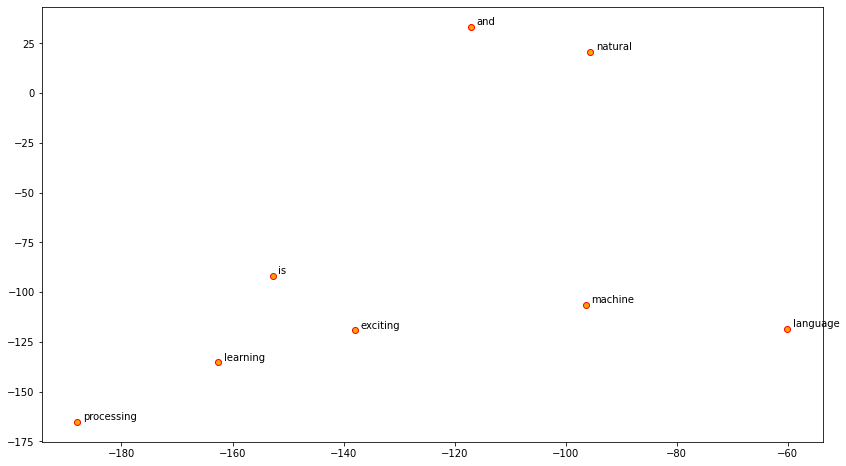

In [240]:
sg = Word2Vec()
wv = sg.embedding(docs, epoch=1000)
print(sg.wv_['natural'])
print(sg.most_similar('natural'))
sg.visualize('natural', 8)

In [241]:
cbow = Word2Vec()
wv = cbow.embedding(docs, method = 'cbow', epoch=1000)
print(cbow.wv_['natural'])
print(cbow.most_similar('natural'))
cbow.visualize('natural', 8)

AttributeError: ignored

##1.2 gensim Word2Vec

In [219]:
from gensim.models import Word2Vec

word2vec = Word2Vec(
    sentences = [d.split() for d in docs],  # 학습시킬 문장
    size = 5,                  # 임베딩된 단어 벡터의 차원 크기
    alpha = 0.01,               # 학습률(Learning rate)
    min_count=2,                 # 2번 미만 등장한 단어는 제외
    window = 2,                  # 문맥의 크기 (window_size)
    sample = 0.001,              # sub-sampling
    sg = 1,                      # 0: CBOW, 1: Skip-gram
    iter = 10                    # 전체 문장 반복학습 횟수(epoch)
    )

In [220]:
word2vec.wv.__getitem__('natural')

array([-0.01871337, -0.08533629,  0.07540572, -0.03936454,  0.00377927],
      dtype=float32)

In [221]:
word2vec.wv.most_similar('natural')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('and', 0.13754040002822876),
 ('machine', 0.06119634956121445),
 ('processing', -0.027662862092256546),
 ('language', -0.5173978805541992),
 ('learning', -0.6756094098091125)]

In [226]:
word2vec.wv[['natural','and']]

array([[-0.01871337, -0.08533629,  0.07540572, -0.03936454,  0.00377927],
       [ 0.04233906, -0.0142344 , -0.03197954, -0.09676962,  0.02978341]],
      dtype=float32)

##1.3 Tensorflow Word2Vec